# Development of `hindcast-dayavgs` Tool

This notebook is about initial development work on a tool to calculate
day-averaged fields files from hour-averaged output files of SalishSeaCast hindcast runs.

The motivations for this tool are:

* Hindcast runs, specifically v201905, were run on the EOAS `optimum` cluster
  which suffers from significant performance degradation as the volume of run
  output increases. Because of that, the v201905 runs do not include day-averaged
  fields calculated by NEMO. But the usefulness of those fields for analysis and 
  model evaluation means that we need to produce them as a post-processing product
  so that individual researchers don't have to generate them on an *ad hoc* basis.
  
* Timing of a selection of `ncra` commands to generate those files (see below)
  provides a baseline to compare the performance of `xarray` and `dask` to.
  `xarray` also provides more control over exclusion of unused variables/coordinates,
  and metadata buffing than `ncra`
  
`environment.yaml` in this directory contains the conda env description for running
this notebook, and the eventual stand-alone `hindcast_dayavgs` tool.

## `ncra` timings on `salish`

Collected while nowcast-dev was running on 8 cores.

```bash
salish:hindcast-dayavgs$ time ncra -4 -L4 -O -v sossheig,votemper,vosaline /results2/SalishSea/nowcast-green.201905/01jan14/SalishSea_1h_20140101_20140101_grid_T.nc /tmp/SalishSea_1d_20140101_20140101_grid_T.nc

real	0m17.907s
user	0m11.628s
sys	0m6.200s
```

```bash
salish:hindcast-dayavgs$ time ncra -4 -L4 -O -v PAR,sigma_theta,e3t,Fraser_tracer,dissolved_inorganic_carbon,total_alkalinity,dissolved_oxygen /results2/SalishSea/nowcast-green.201905/01jan14/SalishSea_1h_20140101_20140101_carp_T.nc /tmp/SalishSea_1d_20140101_20140101_carp_T.nc

real	1m0.615s
user	0m40.036s
sys	0m20.500s
```

```bash
time ncra -4 -L4 -O -v nitrate,ammonium,silicon,diatoms,flagellates,ciliates,microzooplankton,dissolved_organic_nitrogen,particulate_organic_nitrogen,biogenic_silicon,mesozooplankton /results2/SalishSea/nowcast-green.201905/01jan14/SalishSea_1h_20140101_20140101_ptrc_T.nc /tmp/SalishSea_1d_20140101_20140101_ptrc_T.nc

real	1m33.297s
user	1m1.768s
sys	0m31.420s
```

## Setup

In [2]:
from copy import copy
import math
from pathlib import Path
import time

import arrow
import xarray

In [2]:
green_1905 = Path("/results2/SalishSea/nowcast-green.201905")

In [3]:
drop_vars = {
    "axis_nbounds",
    "nvertex",
    "bounds_lon",
    "bounds_lat",
    "area",
    "deptht_bounds",
    "time_centered",
    "time_centered_bounds",
    "time_counter_bounds",
}

In [4]:
day = arrow.get("2014-01-01")
ddmmmyy = day.format('DDMMMYY').lower()
yyyymmdd = day.format('YYYYMMDD')
tracers = "grid_T"
hour_avgs_file = green_1905/f"{ddmmmyy}"/f"SalishSea_1h_{yyyymmdd}_{yyyymmdd}_{tracers}.nc"
hour_avgs_file

PosixPath('/results2/SalishSea/nowcast-green.201905/01jan14/SalishSea_1h_20140101_20140101_grid_T.nc')

## **Notes**

1. To make timings below as consistent as possible,
   the kernel was restarted and the setup cells above re-run before each test.
2. These tests don't include writing the day-averaged fields to netCDF4 files.
   That step is done later because it is somewhat uninteresting in terms of timing
   (though the time to do it must be taken into account for comparison with `ncra`).

## In-memory Processing

Let `xarray` read the entire dataset into memory to calculate the day-averaged fields

In [8]:
t_start = time.time()
hour_avgs = xarray.open_dataset(hour_avgs_file, drop_variables=drop_vars)
print(f"load metadata via open_dataset(): {time.time() - t_start} s")

load metadata via open_dataset(): 0.028700828552246094 s


In [10]:
t_start = time.time()
day_avgs = hour_avgs.resample(time_counter="D").mean(
    dim="time_counter", skipna=True, keep_attrs=True
)
print(f"calc day averages: {time.time() - t_start} s")

calc day averages: 20.506532192230225 s


Apart from being slow, this method tops out at required about 10 Gb of memory
for just the two 4d (`votemper` and `vosaline`) and one 3d (`sossheig`) variables in `grid_T`.
The memory use increases for more variables in `carp_T` and `ptrc_T`.

In [11]:
day_avgs

<xarray.Dataset>
Dimensions:       (deptht: 40, time_counter: 1, x: 398, y: 898)
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 2014-01-01
    nav_lat       (y, x) float32 ...
    nav_lon       (y, x) float32 ...
  * deptht        (deptht) float32 0.5 1.5 2.5 3.5 ... 360.7 387.6 414.5 441.5
Dimensions without coordinates: x, y
Data variables:
    sossheig      (time_counter, y, x) float32 nan nan nan nan ... nan nan nan
    votemper      (time_counter, deptht, y, x) float32 nan nan nan ... nan nan
    vosaline      (time_counter, deptht, y, x) float32 nan nan nan ... nan nan
Attributes:
    name:         SalishSea_1h_20140101_20140105
    description:  ocean T grid variables
    title:        ocean T grid variables
    Conventions:  CF-1.6
    timeStamp:    2019-Sep-19 02:14:06 GMT
    uuid:         70651611-9a7b-40ea-beaf-6d674e2d6f58

# Parallel Processing with `dask`

Providing a `chunks` dict to `open_dataset()` causes processing to be
delegated to a task graph generated and managed by `dask`.
Calculation of the task graph is deferred until we do something that requires
access to the result of the calculation rather than its metadata.
In the tests below we will use `day_avgs.load(...)` to trigger the calculation,
and control how it is parallelized.

First, the parallelization setup:

In [5]:
chunks = {
    "time_counter": 24,
    "deptht": 40,
    "y": 898,
    "x": 398,
}

In [6]:
t_start = time.time()
hour_avgs = xarray.open_dataset(hour_avgs_file, chunks=chunks, drop_variables=drop_vars)
print(f"load metadata via open_dataset(): {time.time() - t_start} s")

load metadata via open_dataset(): 0.10187315940856934 s


In [7]:
print(
    f"chunk size: {math.prod(chunks.values()) * hour_avgs[list(hour_avgs.data_vars)[0]].dtype.itemsize /1024/1024/1024} Gb"
)

chunk size: 1.2781763076782227 Gb


In [8]:
t_start = time.time()
day_avgs = hour_avgs.resample(time_counter="D").mean(
    dim="time_counter", skipna=True, keep_attrs=True
)
print(f"calc day averages: {time.time() - t_start} s")

calc day averages: 0.05004763603210449 s


In [9]:
day_avgs

<xarray.Dataset>
Dimensions:       (deptht: 40, time_counter: 1, x: 398, y: 898)
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 2014-01-01
    nav_lat       (y, x) float32 dask.array<chunksize=(898, 398), meta=np.ndarray>
    nav_lon       (y, x) float32 dask.array<chunksize=(898, 398), meta=np.ndarray>
  * deptht        (deptht) float32 0.5 1.5 2.5 3.5 ... 360.7 387.6 414.5 441.5
Dimensions without coordinates: x, y
Data variables:
    sossheig      (time_counter, y, x) float32 dask.array<chunksize=(1, 898, 398), meta=np.ndarray>
    votemper      (time_counter, deptht, y, x) float32 dask.array<chunksize=(1, 40, 898, 398), meta=np.ndarray>
    vosaline      (time_counter, deptht, y, x) float32 dask.array<chunksize=(1, 40, 898, 398), meta=np.ndarray>
Attributes:
    name:         SalishSea_1h_20140101_20140105
    description:  ocean T grid variables
    title:        ocean T grid variables
    Conventions:  CF-1.6
    timeStamp:    2019-Sep-19 02:14:06 GMT
    uuid:         70651611-9a7b-40ea-beaf-6d674e2d6f58

## Default `dask` Scheduler (Threads)

`dask` default to using lots of threads to calculate the task graph.
However, all of those threads run on the core that our Python interpreter
is running on.

In [10]:
t_start = time.time()
day_avgs.load()
print(f"calc the task graph: {time.time() - t_start} s")

/home/dlatorne/conda_envs/hindcast-dayavgs/lib/python3.9/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


calc the task graph: 15.985585689544678 s


It's a bit faster than the non-chunked, in-memory method,
and it has an even larger memory footprint of about 13 Gb.

Limiting the number of threads doesn't make much difference:

In [9]:
num_workers = 16
t_start = time.time()
day_avgs.load(scheduler="threads", num_workers=num_workers)
print(f"calc the task graph: {time.time() - t_start} s")

/home/dlatorne/conda_envs/hindcast-dayavgs/lib/python3.9/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


calc the task graph: 15.559203147888184 s


## Multi-core `dask` Scheduler (Processes)

This method launches multiple Python interpreters (workers),
each on a separate core, to distribute the calculation of the task graph to.

My test have shown that, for processing daily SalishSeaCast NEMO results,
there is rarely, if ever, advantage to be gains from using more workers than
the number of physical cores on a machine (that's 16 for `salish`).
While `nowcast-dev` is running, 8 cores are occuppied by that workload.
So, provided that nobody else is doing a significant processing task,
we can use 8 cores:

In [10]:
num_workers = 8
t_start = time.time()
day_avgs.load(scheduler="processes", num_workers=num_workers)
print(f"calc the task graph: {time.time() - t_start} s")

calc the task graph: 15.126396656036377 s


Dialing down the number of workers (cores):

In [10]:
num_workers = 7
t_start = time.time()
day_avgs.load(scheduler="processes", num_workers=num_workers)
print(f"calc the task graph: {time.time() - t_start} s")

calc the task graph: 13.945057392120361 s


In [9]:
num_workers = 6
t_start = time.time()
day_avgs.load(scheduler="processes", num_workers=num_workers)
print(f"calc the task graph: {time.time() - t_start} s")

calc the task graph: 13.611520767211914 s


In [10]:
num_workers = 5
t_start = time.time()
day_avgs.load(scheduler="processes", num_workers=num_workers)
print(f"calc the task graph: {time.time() - t_start} s")

calc the task graph: 13.489188194274902 s


In [10]:
num_workers = 4
t_start = time.time()
day_avgs.load(scheduler="processes", num_workers=num_workers)
print(f"calc the task graph: {time.time() - t_start} s")

calc the task graph: 14.161011457443237 s


In [10]:
num_workers = 3
t_start = time.time()
day_avgs.load(scheduler="processes", num_workers=num_workers)
print(f"calc the task graph: {time.time() - t_start} s")

calc the task graph: 13.882383584976196 s


In [10]:
num_workers = 2
t_start = time.time()
day_avgs.load(scheduler="processes", num_workers=num_workers)
print(f"calc the task graph: {time.time() - t_start} s")

calc the task graph: 14.153458833694458 s


In [10]:
num_workers = 1
t_start = time.time()
day_avgs.load(scheduler="processes", num_workers=num_workers)
print(f"calc the task graph: {time.time() - t_start} s")

calc the task graph: 25.22658085823059 s


When `salish` is not busy,
we can benefit from using more of its physical cores:

In [10]:
num_workers = 16
t_start = time.time()
day_avgs.load(scheduler="processes", num_workers=num_workers)
print(f"calc the task graph: {time.time() - t_start} s")

calc the task graph: 11.635323286056519 s


In [10]:
num_workers = 12
t_start = time.time()
day_avgs.load(scheduler="processes", num_workers=num_workers)
print(f"calc the task graph: {time.time() - t_start} s")

calc the task graph: 12.413317680358887 s


In [10]:
num_workers = 10
t_start = time.time()
day_avgs.load(scheduler="processes", num_workers=num_workers)
print(f"calc the task graph: {time.time() - t_start} s")

calc the task graph: 12.137920141220093 s


But the hardward hyper-threading that makes 16 cores look like
32 cores to the operating system does not provide us with a
benefit for this workload:

In [10]:
num_workers = 24
t_start = time.time()
day_avgs.load(scheduler="processes", num_workers=num_workers)
print(f"calc the task graph: {time.time() - t_start} s")

calc the task graph: 13.198112964630127 s


In [10]:
num_workers = 32
t_start = time.time()
day_avgs.load(scheduler="processes", num_workers=num_workers)
print(f"calc the task graph: {time.time() - t_start} s")

calc the task graph: 13.7468421459198 s


## `carp_T` Variables

In [6]:
tracers = "carp_T"
hour_avgs_file = green_1905/f"{ddmmmyy}"/f"SalishSea_1h_{yyyymmdd}_{yyyymmdd}_{tracers}.nc"
hour_avgs_file

PosixPath('/results2/SalishSea/nowcast-green.201905/01jan14/SalishSea_1h_20140101_20140101_carp_T.nc')

In [7]:
t_start = time.time()
hour_avgs = xarray.open_dataset(hour_avgs_file, chunks=chunks, drop_variables=drop_vars)
print(f"load metadata via open_dataset(): {time.time() - t_start} s")

load metadata via open_dataset(): 0.11024904251098633 s


In [8]:
t_start = time.time()
day_avgs = hour_avgs.resample(time_counter="D").mean(
    dim="time_counter", skipna=True, keep_attrs=True
)
print(f"calc day averages: {time.time() - t_start} s")

calc day averages: 0.07105684280395508 s


In [9]:
day_avgs

<xarray.Dataset>
Dimensions:                     (deptht: 40, time_counter: 1, x: 398, y: 898)
Coordinates:
  * time_counter                (time_counter) datetime64[ns] 2014-01-01
    nav_lat                     (y, x) float32 dask.array<chunksize=(898, 398), meta=np.ndarray>
    nav_lon                     (y, x) float32 dask.array<chunksize=(898, 398), meta=np.ndarray>
  * deptht                      (deptht) float32 0.5 1.5 2.5 ... 414.5 441.5
Dimensions without coordinates: x, y
Data variables:
    PAR                         (time_counter, deptht, y, x) float32 dask.array<chunksize=(1, 40, 898, 398), meta=np.ndarray>
    sigma_theta                 (time_counter, deptht, y, x) float32 dask.array<chunksize=(1, 40, 898, 398), meta=np.ndarray>
    e3t                         (time_counter, deptht, y, x) float32 dask.array<chunksize=(1, 40, 898, 398), meta=np.ndarray>
    Fraser_tracer               (time_counter, deptht, y, x) float32 dask.array<chunksize=(1, 40, 898, 398), meta=np.ndarray>
    dissolved_inorganic_carbon  (time_counter, deptht, y, x) float32 dask.array<chunksize=(1, 40, 898, 398), meta=np.ndarray>
    total_alkalinity            (time_counter, deptht, y, x) float32 dask.array<chunksize=(1, 40, 898, 398), meta=np.ndarray>
    dissolved_oxygen            (time_counter, deptht, y, x) float32 dask.array<chunksize=(1, 40, 898, 398), meta=np.ndarray>
Attributes:
    name:         SalishSea_1h_20140101_20140105
    description:  auxilary variables
    title:        auxilary variables
    Conventions:  CF-1.6
    timeStamp:    2019-Sep-19 02:14:06 GMT
    uuid:         ef60bc9c-6763-43e4-a9bc-a5beb66ce88c

In [10]:
num_workers = 8
t_start = time.time()
day_avgs.load(scheduler="processes", num_workers=num_workers)
print(f"calc the task graph: {time.time() - t_start} s")

calc the task graph: 17.228883981704712 s


With more variables (7 in `carp_T` compared to 3 in `grid_T`),
we can make full use of 8 processes/cores.

In [10]:
num_workers = 7
t_start = time.time()
day_avgs.load(scheduler="processes", num_workers=num_workers)
print(f"calc the task graph: {time.time() - t_start} s")

calc the task graph: 18.69329261779785 s


In [10]:
num_workers = 6
t_start = time.time()
day_avgs.load(scheduler="processes", num_workers=num_workers)
print(f"calc the task graph: {time.time() - t_start} s")

calc the task graph: 26.355726718902588 s


In [14]:
num_workers = 5
t_start = time.time()
day_avgs.load(scheduler="processes", num_workers=num_workers)
print(f"calc the task graph: {time.time() - t_start} s")

calc the task graph: 27.783101081848145 s


In [10]:
num_workers = 4
t_start = time.time()
day_avgs.load(scheduler="processes", num_workers=num_workers)
print(f"calc the task graph: {time.time() - t_start} s")

calc the task graph: 27.08739709854126 s


In [10]:
num_workers = 3
t_start = time.time()
day_avgs.load(scheduler="processes", num_workers=num_workers)
print(f"calc the task graph: {time.time() - t_start} s")

calc the task graph: 37.016868352890015 s


In [10]:
num_workers = 2
t_start = time.time()
day_avgs.load(scheduler="processes", num_workers=num_workers)
print(f"calc the task graph: {time.time() - t_start} s")

calc the task graph: 46.37400245666504 s


There is also a benefit to using >8 processes/cores
when `salish` is note busy with `nowcast-dev` or other processing:

In [10]:
num_workers = 16
t_start = time.time()
day_avgs.load(scheduler="processes", num_workers=num_workers)
print(f"calc the task graph: {time.time() - t_start} s")

calc the task graph: 14.747142314910889 s


In [10]:
num_workers = 12
t_start = time.time()
day_avgs.load(scheduler="processes", num_workers=num_workers)
print(f"calc the task graph: {time.time() - t_start} s")

calc the task graph: 14.198343276977539 s


In [10]:
num_workers = 10
t_start = time.time()
day_avgs.load(scheduler="processes", num_workers=num_workers)
print(f"calc the task graph: {time.time() - t_start} s")

calc the task graph: 16.392396211624146 s


Hardware hyper-threading perhaps provides a marginal benefit
for this workload:

In [10]:
num_workers = 32
t_start = time.time()
day_avgs.load(scheduler="processes", num_workers=num_workers)
print(f"calc the task graph: {time.time() - t_start} s")

calc the task graph: 14.63721489906311 s


## `ptrc_T` Variables

This dataset has the most variables of the 3 considered here
(11, vs. 7 for `carp_T`, and 3 for `grid_T`).

In [6]:
tracers = "ptrc_T"
hour_avgs_file = green_1905/f"{ddmmmyy}"/f"SalishSea_1h_{yyyymmdd}_{yyyymmdd}_{tracers}.nc"
hour_avgs_file

PosixPath('/results2/SalishSea/nowcast-green.201905/01jan14/SalishSea_1h_20140101_20140101_ptrc_T.nc')

In [7]:
t_start = time.time()
hour_avgs = xarray.open_dataset(hour_avgs_file, chunks=chunks, drop_variables=drop_vars)
print(f"load metadata via open_dataset(): {time.time() - t_start} s")

load metadata via open_dataset(): 0.12580657005310059 s


In [8]:
t_start = time.time()
day_avgs = hour_avgs.resample(time_counter="D").mean(
    dim="time_counter", skipna=True, keep_attrs=True
)
print(f"calc day averages: {time.time() - t_start} s")

calc day averages: 0.09316778182983398 s


In [9]:
day_avgs

<xarray.Dataset>
Dimensions:                       (deptht: 40, time_counter: 1, x: 398, y: 898)
Coordinates:
  * time_counter                  (time_counter) datetime64[ns] 2014-01-01
    nav_lat                       (y, x) float32 dask.array<chunksize=(898, 398), meta=np.ndarray>
    nav_lon                       (y, x) float32 dask.array<chunksize=(898, 398), meta=np.ndarray>
  * deptht                        (deptht) float32 0.5 1.5 2.5 ... 414.5 441.5
Dimensions without coordinates: x, y
Data variables:
    nitrate                       (time_counter, deptht, y, x) float32 dask.array<chunksize=(1, 40, 898, 398), meta=np.ndarray>
    ammonium                      (time_counter, deptht, y, x) float32 dask.array<chunksize=(1, 40, 898, 398), meta=np.ndarray>
    silicon                       (time_counter, deptht, y, x) float32 dask.array<chunksize=(1, 40, 898, 398), meta=np.ndarray>
    diatoms                       (time_counter, deptht, y, x) float32 dask.array<chunksize=(1, 40, 898, 398), meta=np.ndarray>
    flagellates                   (time_counter, deptht, y, x) float32 dask.array<chunksize=(1, 40, 898, 398), meta=np.ndarray>
    ciliates                      (time_counter, deptht, y, x) float32 dask.array<chunksize=(1, 40, 898, 398), meta=np.ndarray>
    microzooplankton              (time_counter, deptht, y, x) float32 dask.array<chunksize=(1, 40, 898, 398), meta=np.ndarray>
    dissolved_organic_nitrogen    (time_counter, deptht, y, x) float32 dask.array<chunksize=(1, 40, 898, 398), meta=np.ndarray>
    particulate_organic_nitrogen  (time_counter, deptht, y, x) float32 dask.array<chunksize=(1, 40, 898, 398), meta=np.ndarray>
    biogenic_silicon              (time_counter, deptht, y, x) float32 dask.array<chunksize=(1, 40, 898, 398), meta=np.ndarray>
    mesozooplankton               (time_counter, deptht, y, x) float32 dask.array<chunksize=(1, 40, 898, 398), meta=np.ndarray>
Attributes:
    name:         SalishSea_1h_20140101_20140105
    description:  biogeochemical variables
    title:        biogeochemical variables
    Conventions:  CF-1.6
    timeStamp:    2019-Sep-19 02:14:09 GMT
    uuid:         66f0be50-a7ae-47d5-872d-324d5896e640

In [10]:
num_workers = 8
t_start = time.time()
day_avgs.load(scheduler="processes", num_workers=num_workers)
print(f"calc the task graph: {time.time() - t_start} s")

calc the task graph: 25.43069100379944 s


In [10]:
num_workers = 7
t_start = time.time()
day_avgs.load(scheduler="processes", num_workers=num_workers)
print(f"calc the task graph: {time.time() - t_start} s")

calc the task graph: 29.5406436920166 s


In [10]:
num_workers = 6
t_start = time.time()
day_avgs.load(scheduler="processes", num_workers=num_workers)
print(f"calc the task graph: {time.time() - t_start} s")

calc the task graph: 26.355726718902588 s


In [14]:
num_workers = 5
t_start = time.time()
day_avgs.load(scheduler="processes", num_workers=num_workers)
print(f"calc the task graph: {time.time() - t_start} s")

calc the task graph: 27.783101081848145 s


In [10]:
num_workers = 4
t_start = time.time()
day_avgs.load(scheduler="processes", num_workers=num_workers)
print(f"calc the task graph: {time.time() - t_start} s")

calc the task graph: 27.08739709854126 s


In [10]:
num_workers = 3
t_start = time.time()
day_avgs.load(scheduler="processes", num_workers=num_workers)
print(f"calc the task graph: {time.time() - t_start} s")

calc the task graph: 37.016868352890015 s


Using >8 processes/cores when `salish` is not busy
provides even more benefit for this workload than for the datasets
containing feweer variables:

In [10]:
num_workers = 16
t_start = time.time()
day_avgs.load(scheduler="processes", num_workers=num_workers)
print(f"calc the task graph: {time.time() - t_start} s")

calc the task graph: 17.33804965019226 s


In [10]:
num_workers = 12
t_start = time.time()
day_avgs.load(scheduler="processes", num_workers=num_workers)
print(f"calc the task graph: {time.time() - t_start} s")

calc the task graph: 18.06649923324585 s


In [10]:
num_workers = 10
t_start = time.time()
day_avgs.load(scheduler="processes", num_workers=num_workers)
print(f"calc the task graph: {time.time() - t_start} s")

calc the task graph: 25.208957195281982 s


There may even be a small benefit to using the hardware
hyper-threading, but it is debatable:

In [10]:
num_workers = 32
t_start = time.time()
day_avgs.load(scheduler="processes", num_workers=num_workers)
print(f"calc the task graph: {time.time() - t_start} s")

calc the task graph: 17.129926919937134 s


In [35]:
day_avgs.time_counter.attrs.update({
    "time_origin": ds.time_counter.attrs["time_origin"],
    "standard_name": ds.time_counter.attrs["standard_name"],
    "long_name": ds.time_counter.attrs["long_name"],
    "_NoFill": "true",
})

In [10]:
encoding = {
    var: {
        "zlib": True, 
        "chunksizes": [1, 40, 898, 398]
    } for var in day_avgs.data_vars
}
encoding["time_counter"] = {
    "dtype": "d",
    "calendar": "gregorian",
    "units": "seconds since 1900-01-01 00:00:00",
    "chunksizes": [1],
    "_FillValue": None,
}
t_start = time.time()
day_avgs.to_netcdf(Path("/tmp")/f"SalishSea_1d_{yyyymmdd}_{yyyymmdd}_{tracers}_dask.nc", encoding=encoding)
print(f"write day avgs to .nc file: {time.time() - t_start} s")

write day avgs to .nc file: 9.716030359268188 s


In [43]:
in_chunks = {
    "time_counter": 24,
    "deptht": 40,
    "y": 898,
    "x": 398,
}
out_chunks = {
    "time_counter": 1,
    "deptht": 40,
    "y": 898,
    "x": 398,
}
out_chunks_4d = list(out_chunks.values())
out_chunks_3d = copy(out_chunks_4d)
out_chunks_3d.remove(out_chunks["deptht"])
drop_vars = {
    "axis_nbounds",
    "nvertex",
    "bounds_lon",
    "bounds_lat",
    "area",
    "deptht_bounds",
    "time_centered",
    "time_centered_bounds",
    "time_counter_bounds",
}
tracer_groups = ("grid_T", "carp_T", "ptrc_T")
green_1905 = Path("/results2/SalishSea/nowcast-green.201905")

In [45]:
start_date, end_date = arrow.get("2014-01-01"), arrow.get("2014-01-02")
num_workers = 12

In [46]:
t_start_total = time.time()
for day in arrow.Arrow.range("day", start_date, end_date):
    t_start_day = time.time()
    ddmmmyy = day.format('DDMMMYY').lower()
    yyyymmdd = day.format('YYYYMMDD')
    for tracer_group in tracer_groups:
        t_start_tracer = time.time()
        hour_avgs_file = green_1905/f"{ddmmmyy}"/f"SalishSea_1h_{yyyymmdd}_{yyyymmdd}_{tracer_group}.nc"
        hour_avgs = xarray.open_dataset(hour_avgs_file, chunks=in_chunks, drop_variables=drop_vars)
        day_avgs = hour_avgs.resample(time_counter="D").mean(
            dim="time_counter", skipna=True, keep_attrs=True
        )
        day_avgs.load(scheduler="processes", num_workers=num_workers)
        day_avgs.time_counter.attrs.update({
            "time_origin": hour_avgs.time_counter.attrs["time_origin"],
            "standard_name": hour_avgs.time_counter.attrs["standard_name"],
            "long_name": hour_avgs.time_counter.attrs["long_name"],
            "_NoFill": "true",
        })
        day_avgs_file = green_1905/f"{ddmmmyy}"/f"SalishSea_1d_{yyyymmdd}_{yyyymmdd}_{tracer_group}.nc"
        encoding = {
            var: {
                "zlib": True, 
                "chunksizes": out_chunks_4d if day_avgs[var].ndim == 4 else out_chunks_3d
            } for var in day_avgs.data_vars
        }
        encoding["time_counter"] = {
            "dtype": "d",
            "calendar": "gregorian",
            "units": "seconds since 1900-01-01 00:00:00",
            "chunksizes": [1],
            "_FillValue": None,
        }
        day_avgs.to_netcdf(day_avgs_file, encoding=encoding)
        print(f"{ddmmmyy} {tracer_group}: {time.time() - t_start_tracer} s")
    print(f"{ddmmmyy}: {time.time() - t_start_day} s")
print(f"total: {time.time() - t_start_total} s")

01jan14 grid_T: 14.716418266296387 s
01jan14 carp_T: 20.743958950042725 s
01jan14 ptrc_T: 25.615475177764893 s
01jan14: 61.07711887359619 s
02jan14 grid_T: 17.750022888183594 s
02jan14 carp_T: 20.65268349647522 s
02jan14 ptrc_T: 26.809048175811768 s
02jan14: 65.21391320228577 s
total: 126.29753756523132 s


## Verification Against NEMO Day-Averaged Fields

Verify the calculation method developed here by comparing its fields
with those calculated by NEMO in the v201812 hindcast runs.

In [3]:
in_chunks = {
    "time_counter": 24,
    "deptht": 40,
    "y": 898,
    "x": 398,
}
out_chunks = {
    "time_counter": 1,
    "deptht": 40,
    "y": 898,
    "x": 398,
}
out_chunks_4d = list(out_chunks.values())
out_chunks_3d = copy(out_chunks_4d)
out_chunks_3d.remove(out_chunks["deptht"])
drop_vars = {
    "axis_nbounds",
    "nvertex",
    "bounds_lon",
    "bounds_lat",
    "area",
    "deptht_bounds",
    "time_centered",
    "time_centered_bounds",
    "time_counter_bounds",
}
tracer_groups = ("grid_T", "carp_T", "ptrc_T")
green_1812 = Path("/results/SalishSea/nowcast-green.201812")

In [4]:
start_date, end_date = arrow.get("2015-01-01"), arrow.get("2015-01-01")
num_workers = 16

In [15]:
t_start_total = time.time()
for day in arrow.Arrow.range("day", start_date, end_date):
    t_start_day = time.time()
    ddmmmyy = day.format('DDMMMYY').lower()
    yyyymmdd = day.format('YYYYMMDD')
    for tracer_group in tracer_groups:
        t_start_tracer = time.time()
        hour_avgs_file = green_1812/f"{ddmmmyy}"/f"SalishSea_1h_{yyyymmdd}_{yyyymmdd}_{tracer_group}.nc"
        hour_avgs = xarray.open_dataset(hour_avgs_file, chunks=in_chunks, drop_variables=drop_vars)
        day_avgs = hour_avgs.resample(time_counter="D").mean(
            dim="time_counter", skipna=True, keep_attrs=True
        )
        day_avgs.load(scheduler="processes", num_workers=num_workers)
        day_avgs.time_counter.attrs.update({
            "time_origin": hour_avgs.time_counter.attrs["time_origin"],
            "standard_name": hour_avgs.time_counter.attrs["standard_name"],
            "long_name": hour_avgs.time_counter.attrs["long_name"],
            "_NoFill": "true",
        })
        day_avgs_file = Path("/tmp/")/f"SalishSea_1d_{yyyymmdd}_{yyyymmdd}_{tracer_group}_1812.nc"
        encoding = {
            var: {
                "zlib": True, 
                "chunksizes": out_chunks_4d if day_avgs[var].ndim == 4 else out_chunks_3d
            } for var in day_avgs.data_vars
        }
        encoding["time_counter"] = {
            "dtype": "d",
            "calendar": "gregorian",
            "units": "seconds since 1900-01-01 00:00:00",
            "chunksizes": [1],
            "_FillValue": None,
        }
        day_avgs.to_netcdf(day_avgs_file, encoding=encoding)
        print(f"{ddmmmyy} {tracer_group}: {time.time() - t_start_tracer} s")
    print(f"{ddmmmyy}: {time.time() - t_start_day} s")
print(f"total: {time.time() - t_start_total} s")

01jan15 grid_T: 18.1990225315094 s
01jan15 carp_T: 27.013506412506104 s
01jan15 ptrc_T: 51.61459684371948 s
01jan15: 96.82824397087097 s
total: 96.83137321472168 s


In [5]:
import cmocean
import matplotlib.pyplot as plt
%matplotlib inline

In [22]:
def comp_plots(vars, nemo_ds, resampled_ds):
    for var, (nemo_var, cmap) in vars.items():
        fig, (ax_nemo, ax_resampled, ax_diff) = plt.subplots(1, 3, figsize=(16, 9))
        if nemo_ds[nemo_var].ndim == 3:
            nemo = {
                var: nemo_ds[nemo_var].isel(time_counter=0),
            }
            resampled = {
                var: resampled_ds[nemo_var].isel(time_counter=0)
            }
        else:
            nemo = {
                var: nemo_ds[nemo_var].isel(time_counter=0, deptht=0),
            }
            resampled = {
                var: resampled_ds[nemo_var].isel(time_counter=0, deptht=0)
            }
        nemo[var].plot(ax=ax_nemo, cmap=cmap)
        ax_nemo.set_title(f"NEMO day-avg {var}")
        resampled[var].plot(ax=ax_resampled, cmap=cmap)
        ax_resampled.set_title(f"resampled day-avg {var}")
        (nemo[var] - resampled[var]).plot(ax=ax_diff, cmap=cmocean.cm.balance)
        ax_diff.set_title("NEMO - resampled")

In [18]:
ddmmmyy = start_date.format('DDMMMYY').lower()
yyyymmdd = start_date.format('YYYYMMDD')

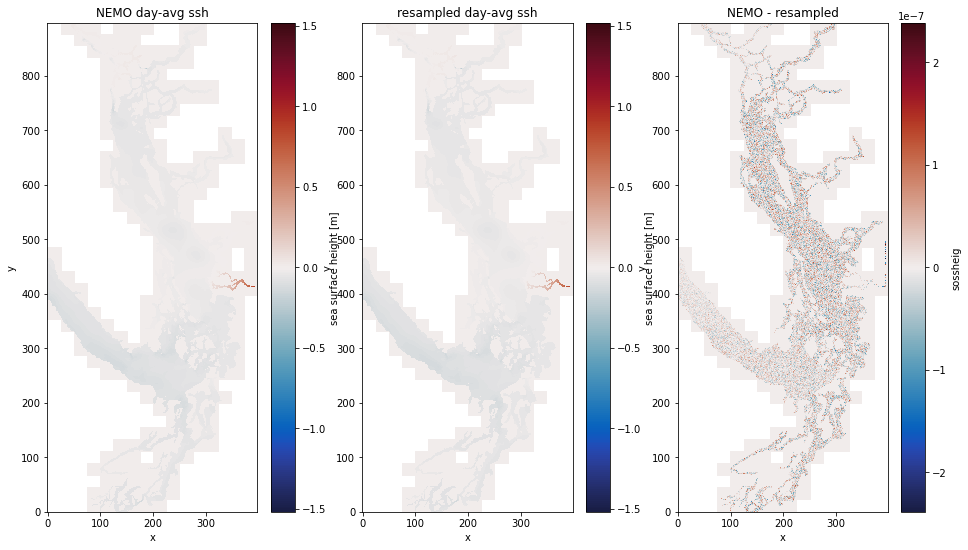

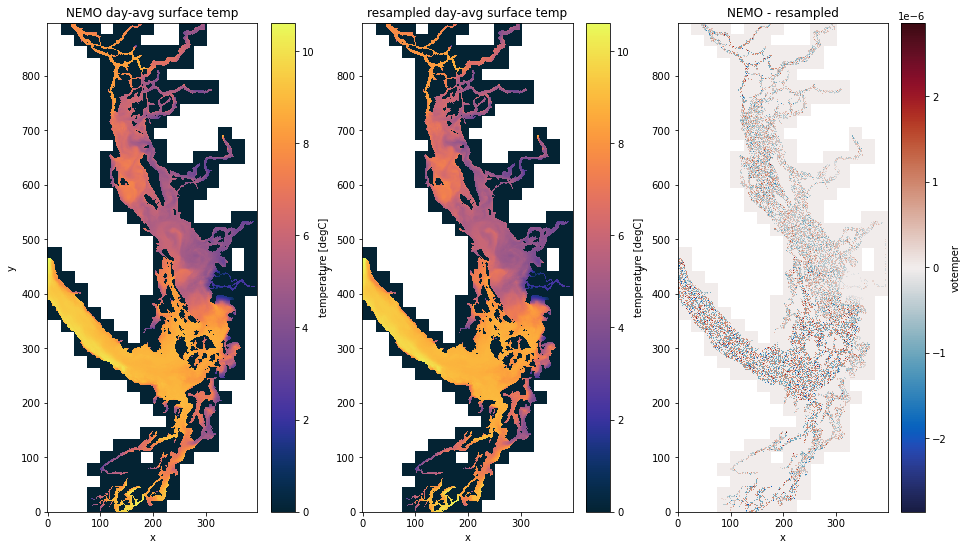

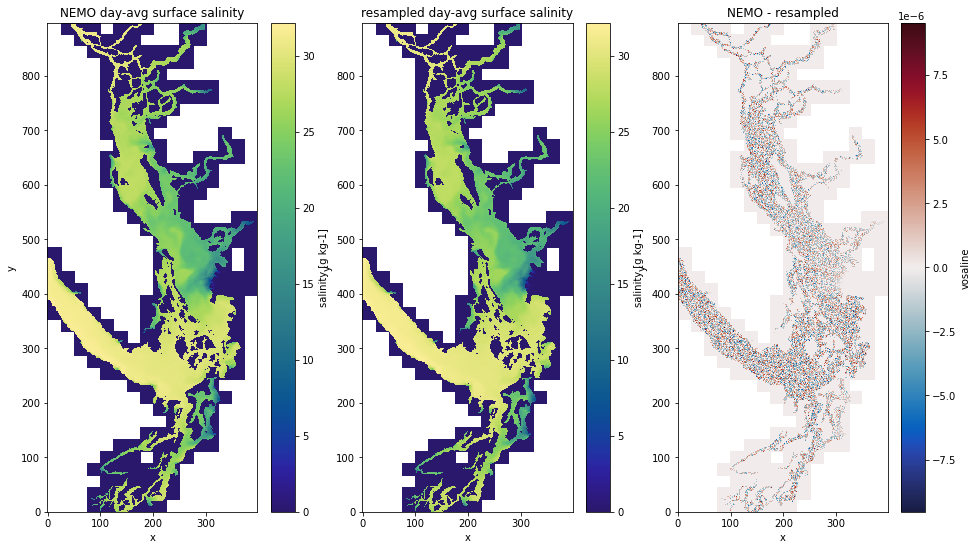

In [8]:
tracer_group = "grid_T"
grid_t_nemo = xarray.open_dataset(green_1812/f"{ddmmmyy}"/f"SalishSea_1d_{yyyymmdd}_{yyyymmdd}_{tracer_group}.nc")
grid_t_resampled = xarray.open_dataset(Path("/tmp/")/f"SalishSea_1d_{yyyymmdd}_{yyyymmdd}_{tracer_group}_1812.nc")

vars = {
    "ssh": ("sossheig", cmocean.cm.balance),
    "surface temp": ("votemper", cmocean.cm.thermal),
    "surface salinity": ("vosaline", cmocean.cm.haline),
}
comp_plots(vars, grid_t_nemo, grid_t_resampled)

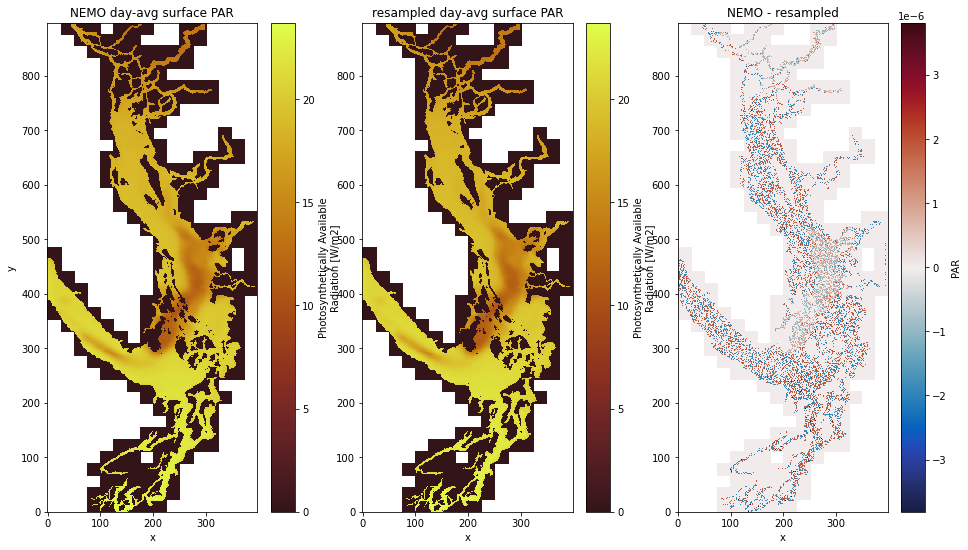

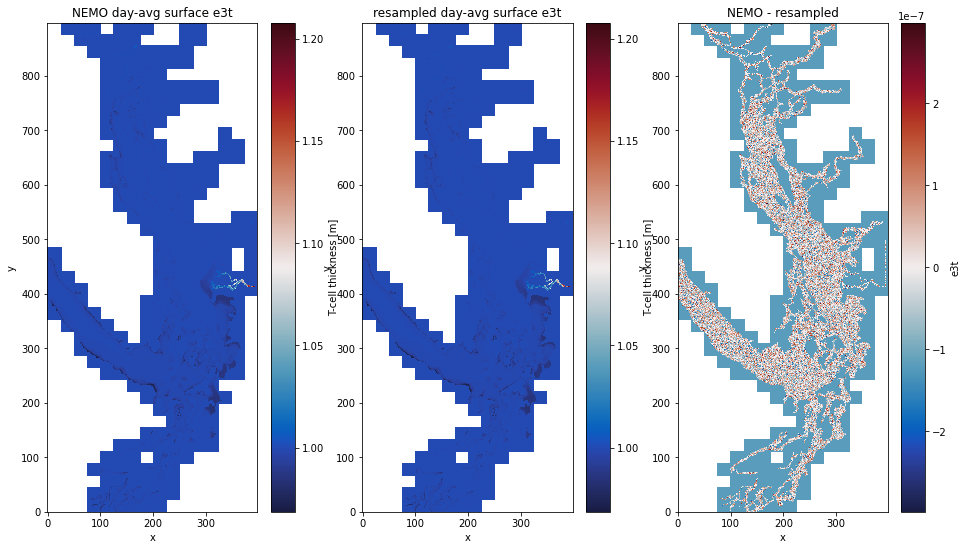

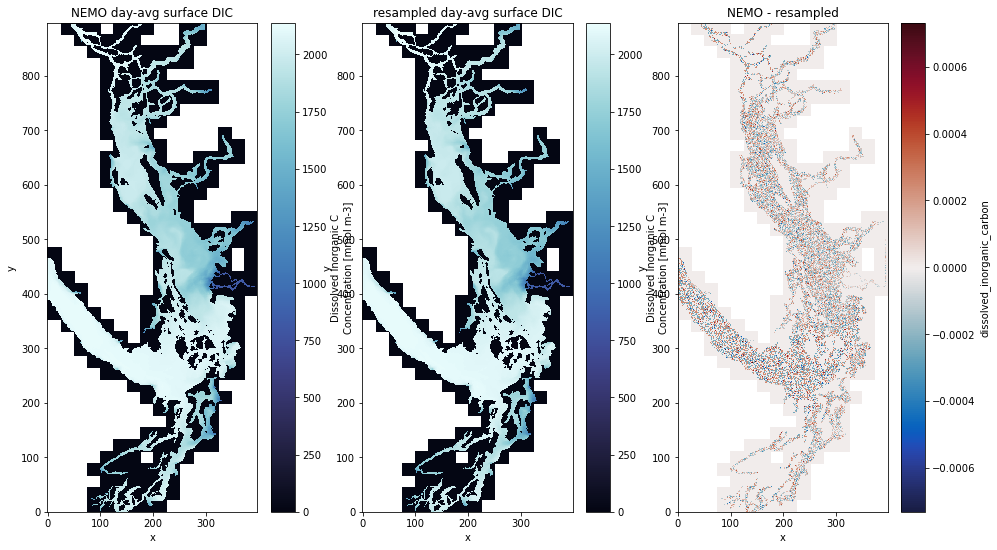

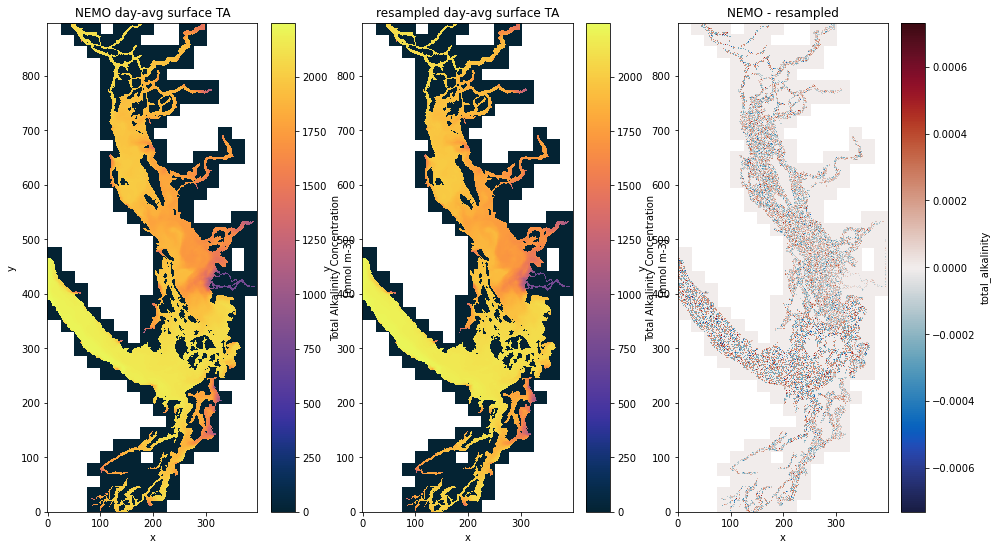

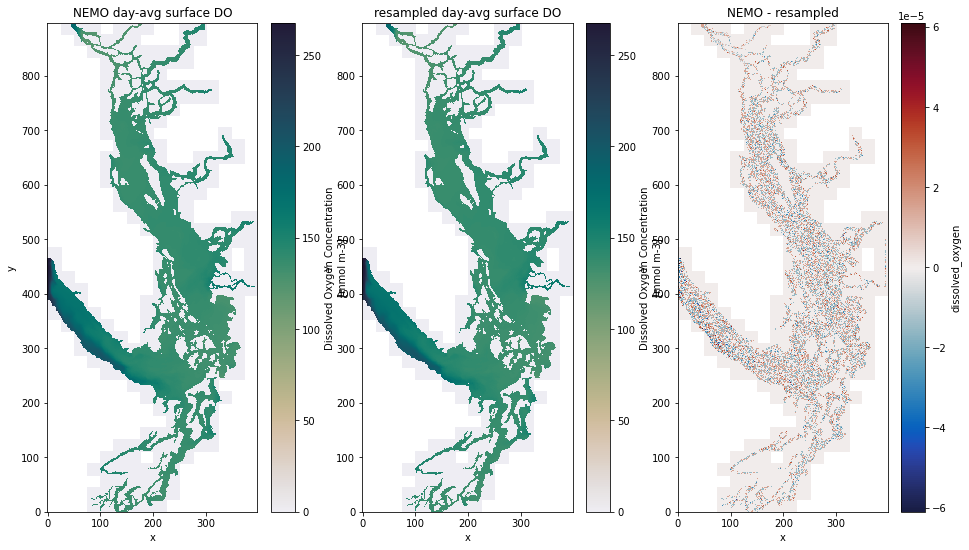

In [56]:
tracer_group = "carp_T"
carp_t_nemo = xarray.open_dataset(green_1812/f"{ddmmmyy}"/f"SalishSea_1d_{yyyymmdd}_{yyyymmdd}_{tracer_group}.nc")
carp_t_resampled = xarray.open_dataset(Path("/tmp/")/f"SalishSea_1d_{yyyymmdd}_{yyyymmdd}_{tracer_group}_1812.nc")

# PAR,sigma_theta,e3t,Fraser_tracer,dissolved_inorganic_carbon,total_alkalinity,dissolved_oxygen
vars = {
    "surface PAR": ("PAR", cmocean.cm.solar),
    "surface e3t": ("e3t", cmocean.cm.balance),
    "surface DIC": ("dissolved_inorganic_carbon", cmocean.cm.ice),
    "surface TA": ("total_alkalinity", cmocean.cm.thermal),
    "surface DO": ("dissolved_oxygen", cmocean.cm.rain),
}
comp_plots(vars, carp_t_nemo, carp_t_resampled)

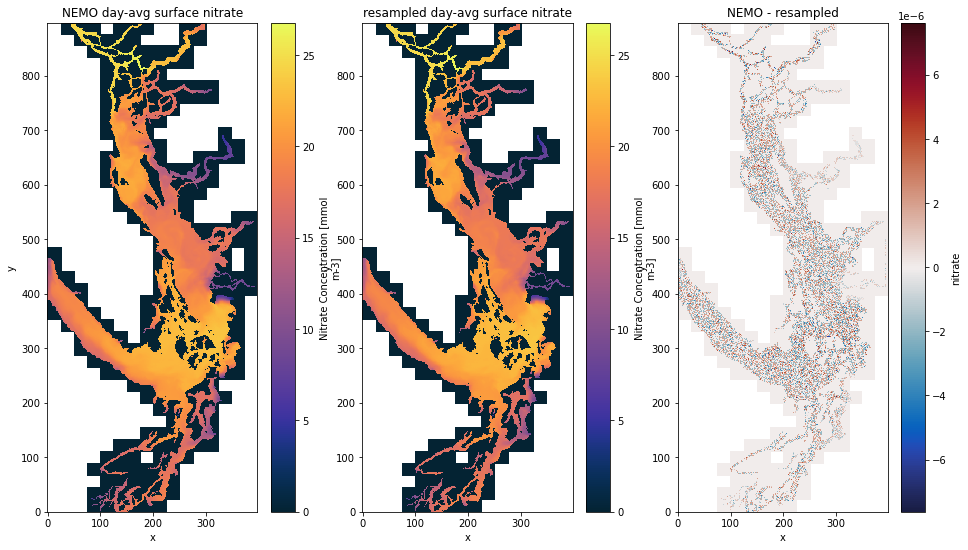

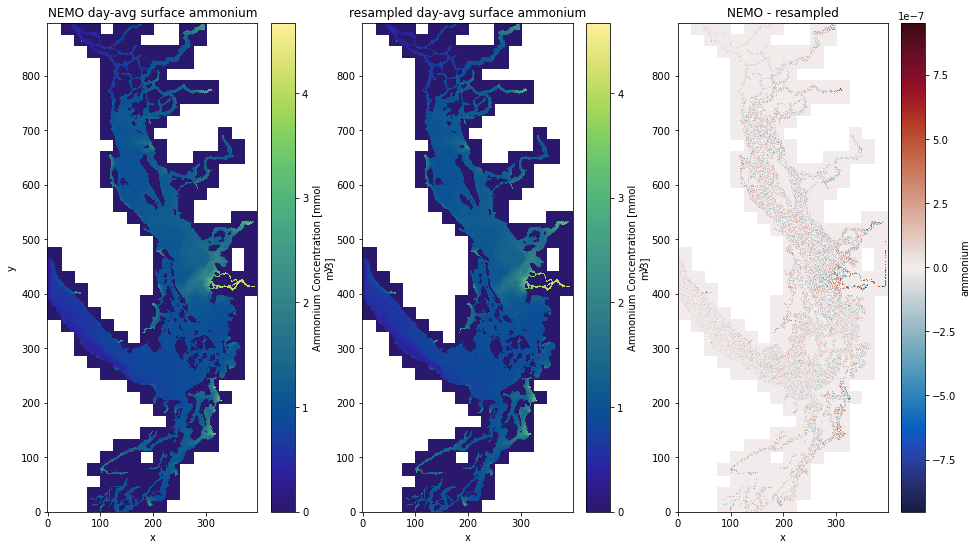

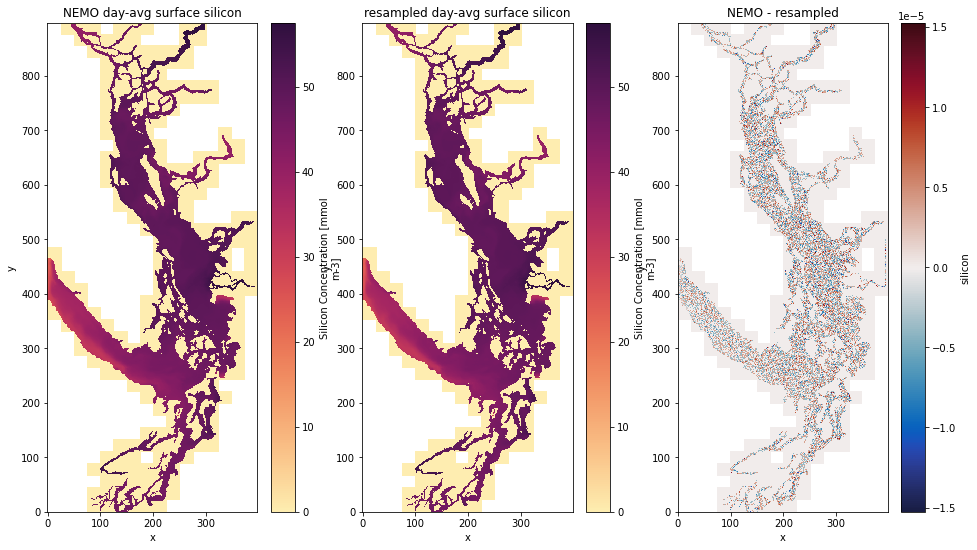

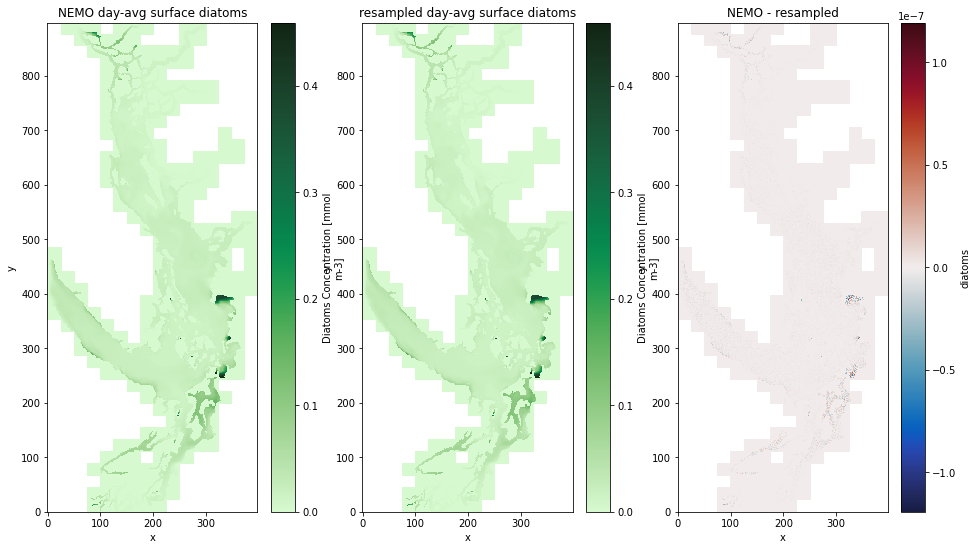

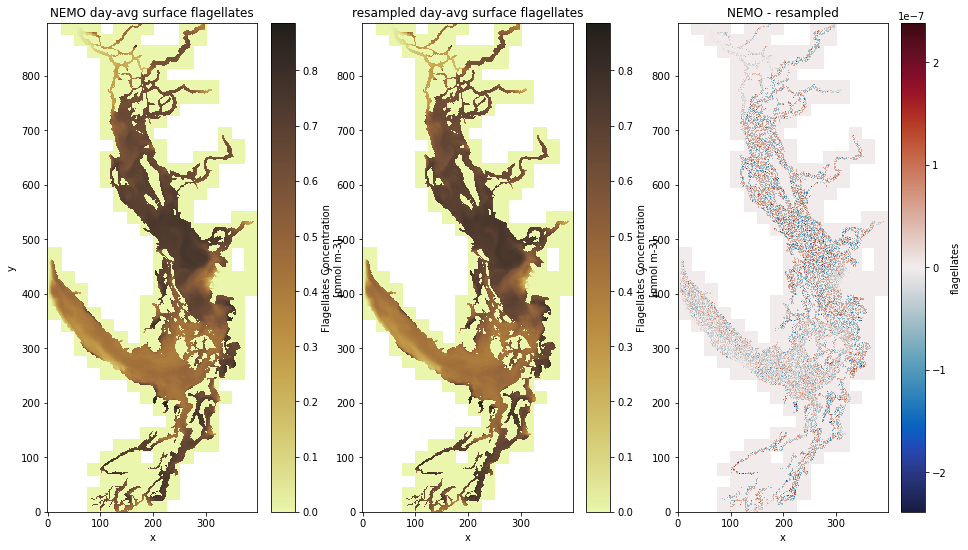

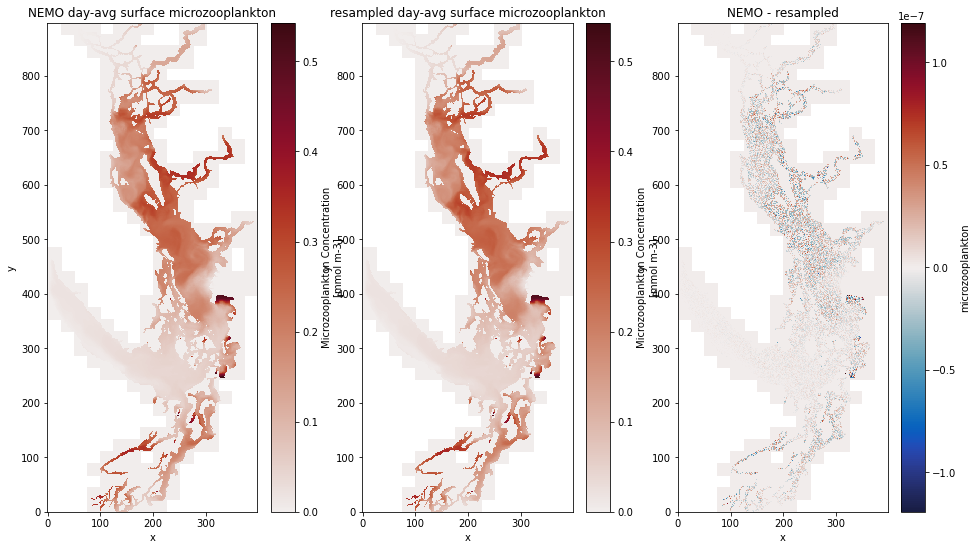

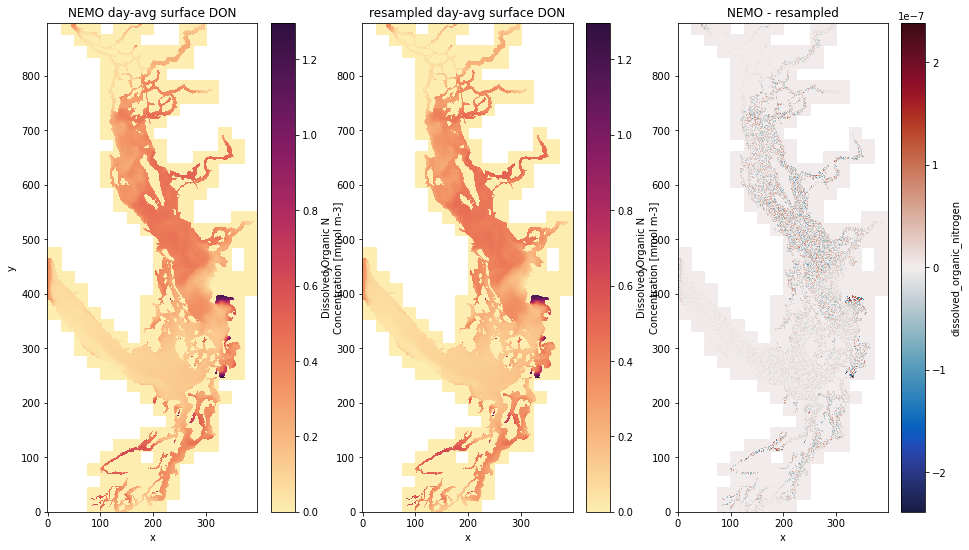

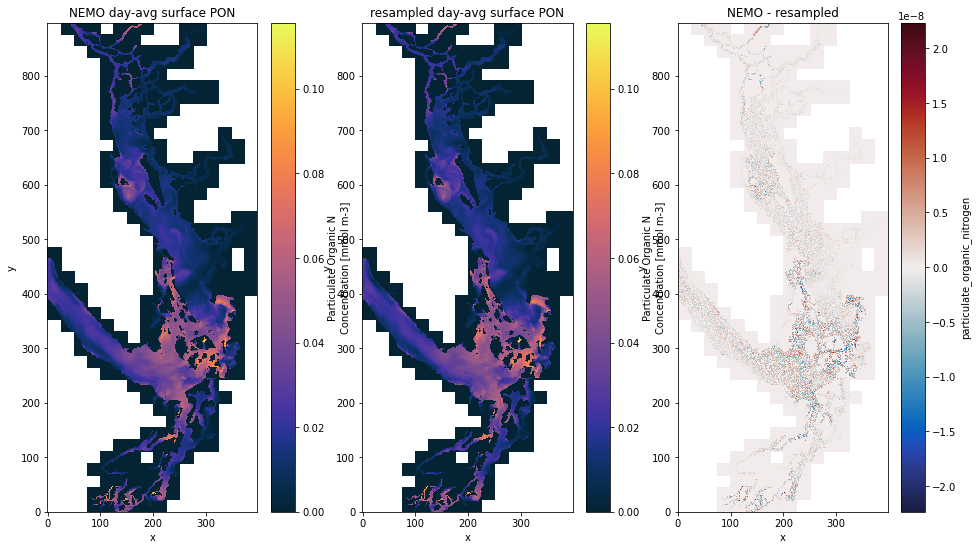

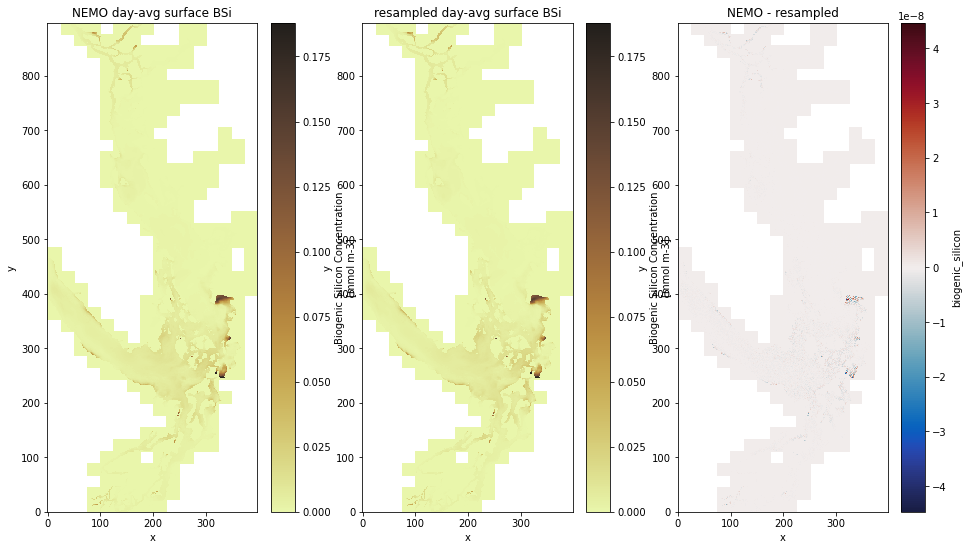

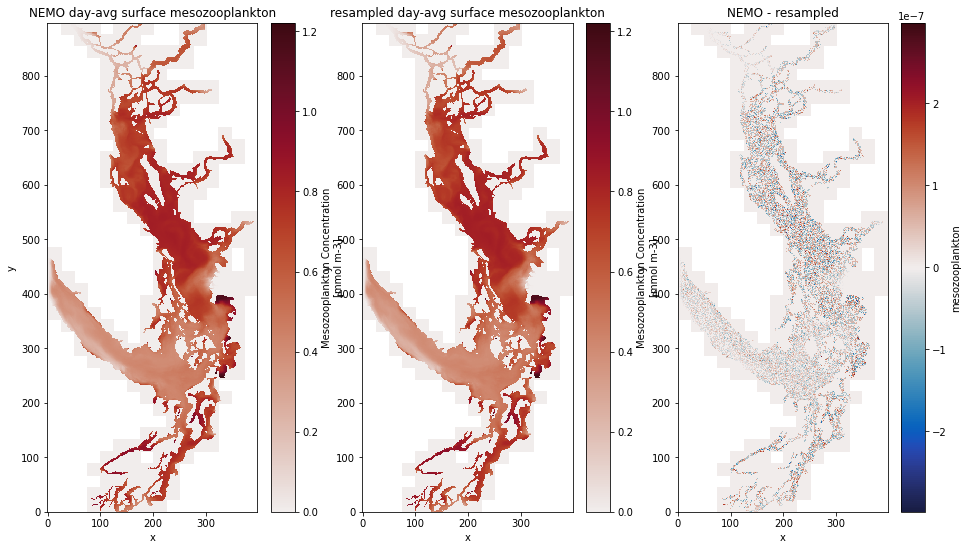

In [27]:
tracer_group = "ptrc_T"
ptrc_t_nemo = xarray.open_dataset(green_1812/f"{ddmmmyy}"/f"SalishSea_1d_{yyyymmdd}_{yyyymmdd}_{tracer_group}.nc")
ptrc_t_resampled = xarray.open_dataset(Path("/tmp/")/f"SalishSea_1d_{yyyymmdd}_{yyyymmdd}_{tracer_group}_1812.nc")

vars = {
    "surface nitrate": ("nitrate", cmocean.cm.thermal),
    "surface ammonium": ("ammonium", cmocean.cm.haline),
    "surface silicon": ("silicon", cmocean.cm.matter),
    "surface diatoms": ("diatoms", cmocean.cm.algae),
    "surface flagellates": ("flagellates", cmocean.cm.turbid),
    "surface microzooplankton": ("microzooplankton", cmocean.cm.amp),
    "surface DON": ("dissolved_organic_nitrogen", cmocean.cm.matter),
    "surface PON": ("particulate_organic_nitrogen", cmocean.cm.thermal),
    "surface BSi": ("biogenic_silicon", cmocean.cm.turbid),
    "surface mesozooplankton": ("mesozooplankton", cmocean.cm.amp),
}
comp_plots(vars, ptrc_t_nemo, ptrc_t_resampled)